In [2]:
from Neural import NeuralNet
from Neural import stratified_split

In [3]:
from sklearn.datasets import load_digits

In [10]:
digits = load_digits()
X, y = digits.data, digits.target

print("Shape de X:", X.shape)   # (1797, 64)
print("Shape de y:", y.shape)   # (1797,)
print("Clases:", set(y))        # {0,1,2,...,9}
print("Número de muestras:", len(y))
print("Número de features:", X.shape[1])
print("Dimensión de cada imagen:", digits.images[0].shape)

Shape de X: (1797, 64)
Shape de y: (1797,)
Clases: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)}
Número de muestras: 1797
Número de features: 64
Dimensión de cada imagen: (8, 8)


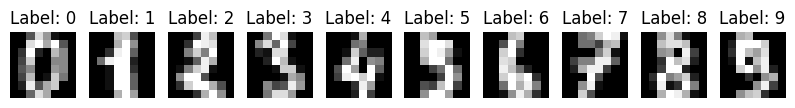

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 10, figsize=(10,3))
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f"Label: {digits.target[i]}")
    ax.axis('off')
plt.show()


In [ ]:
#para probar nomas
modelo1 = NeuralNet(learning_rate=0.001, 
                  activation_function='ReLu', 
                  layer_neurons=[6,4], 
                  epoch=2000, 
                  batch_size=16)

X = iris.data.features.to_numpy()
y = iris.data.targets.to_numpy()
if y.ndim > 1:   # aplastar etiquetas
    y = y.ravel()


# escalar para que tenga media 0 y desviacion estandar 1
X = (X - X.mean(axis=0)) / X.std(axis=0)

X_train, X_test, y_train, y_test = stratified_split(X, y, test_size=0.3, seed=7)

modelo1.fit(X_train, y_train)

y_pred = modelo1.predict(X_test)
# mapear y_test a índices de train
class_to_idx = {c:i for i,c in enumerate(modelo1.classes)}
y_test_idx = np.array([class_to_idx[label] for label in y_test])

test_acc = np.mean(y_pred == y_test_idx)
print(f"Accuracy test: {test_acc:.3f}")
#perdida test
y_pred_test, _, _ = modelo1._forward(X_test)
print(f"Loss test: {modelo1._CategoricalCrossEntropy(y_test_idx, y_pred_test):.3f}")